# Invisible Labor

**Import Dependencies**

In [1]:
import pandas
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Sets up seaborn for graphs to have grids
sns.set(color_codes=True)

Use this cell to import Toloka Data

In [2]:
# Reads in CSV, drops the first row with offset headings, sets new headings, and drops the two irrelevant columns
df_toloka = pd.read_csv("data/telemetry_db.csv")
df_toloka.drop(0)
df_toloka.columns = ['ID', 'Current', 'Event', 'Extra', 'Platform', 'Skip', 'Subtype', 'Time', 'Type', 'User', 'Irrelevant', 'Unused']
df_toloka = df_toloka.drop(columns=['Irrelevant', 'Unused'])

In [3]:
print(df_toloka.info())
df_toloka.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894936 entries, 0 to 2894935
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ID        int64  
 1   Current   object 
 2   Event     object 
 3   Extra     object 
 4   Platform  object 
 5   Skip      float64
 6   Subtype   object 
 7   Time      float64
 8   Type      object 
 9   User      object 
dtypes: float64(2), int64(1), object(7)
memory usage: 220.9+ MB
None


,ID,Current,Event,Extra,Platform,Skip,Subtype,Time,Type,User
0,495553,https://toloka.yandex.com/task/31577897/0001e1...,PAGE_LOAD,NaN,TOLOKA,0.0,TASK_STARTED,1.290745e+12,WORKING,311ad54dd8763dd3365ea2342627aaf
1,1605885,https://toloka.yandex.com/tasks,TAB_CLOSED,NaN,TOLOKA,0.0,TASKS_LIST,1.351745e+12,SEARCHING,fd978fa116dde1ead273fa5fc7316697
2,0,https://toloka.yandex.com/tasks,PAGE_BLUR,NaN,TOLOKA,NaN,TASKS_LIST,1.642014e+12,SEARCHING,d75e96a84a13b15a1f6291c4c8df8b
3,0,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,NaN,TOLOKA,0.0,TASK_STARTED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10
4,1,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,NaN,TOLOKA,0.0,TASK_SUBMITED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10


# DATA CLEANING
- Toloka 'Extra' Column Removal

In [4]:
df_toloka = df_toloka.drop(columns=['Extra', 'Skip'])
df_toloka = df_toloka.dropna()
df_toloka.head()


,ID,Current,Event,Platform,Subtype,Time,Type,User
0,495553,https://toloka.yandex.com/task/31577897/0001e1...,PAGE_LOAD,TOLOKA,TASK_STARTED,1.290745e+12,WORKING,311ad54dd8763dd3365ea2342627aaf
1,1605885,https://toloka.yandex.com/tasks,TAB_CLOSED,TOLOKA,TASKS_LIST,1.351745e+12,SEARCHING,fd978fa116dde1ead273fa5fc7316697
2,0,https://toloka.yandex.com/tasks,PAGE_BLUR,TOLOKA,TASKS_LIST,1.642014e+12,SEARCHING,d75e96a84a13b15a1f6291c4c8df8b
3,0,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,TOLOKA,TASK_STARTED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10
4,1,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,TOLOKA,TASK_SUBMITED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10


### TOLOKA_SURVEY_DATA Cleaning

In [5]:
df_toloka_survey = pd.read_csv("data/toloka_survey_data.csv")
df_toloka_short = df_toloka_survey[['id', 'task_satisfaction', 'task_motivation',  'gender', 'age', 'current_country', 'home_country', 'only_one_country', 'education', 'group', 'freq_use', 'length_use', 'ability_find_tasks', 'promptly_find_tasks']].copy()
df_toloka_short = df_toloka_short.dropna()
df_toloka_short.head()

,id,task_satisfaction,task_motivation,gender,age,current_country,home_country,only_one_country,education,group,freq_use,length_use,ability_find_tasks,promptly_find_tasks
0,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5,Female,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5,Female,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2,27fab4b7ccdc585dc35897de76e44a8c,Slightly Agree,5,Male,18-24 years old,Pakistan,Pakistan,Yes,Bachelor’s degree,treatment,From three to four days a week,Between 3 and 6 months,Neutral,Agree
3,356cd2c5f07830925f6a46ee42e9c748,Slightly Agree,5,Female,18-24 years old,Brazil,Brazil,Yes,"High school graduate, diploma or the equivalen...",treatment,Everyday,More than 2 and 3 years,Strongly Agree,Strongly Agree
4,25daec93559c8d639738bb2c2d8f3194,Neutral,5,Male,25-34 years old,Brazil,Brazil,Yes,"High school graduate, diploma or the equivalen...",treatment,Everyday,Between 3 and 6 months,Neutral,Disagree


Text(0.5, 0, 'Workers')

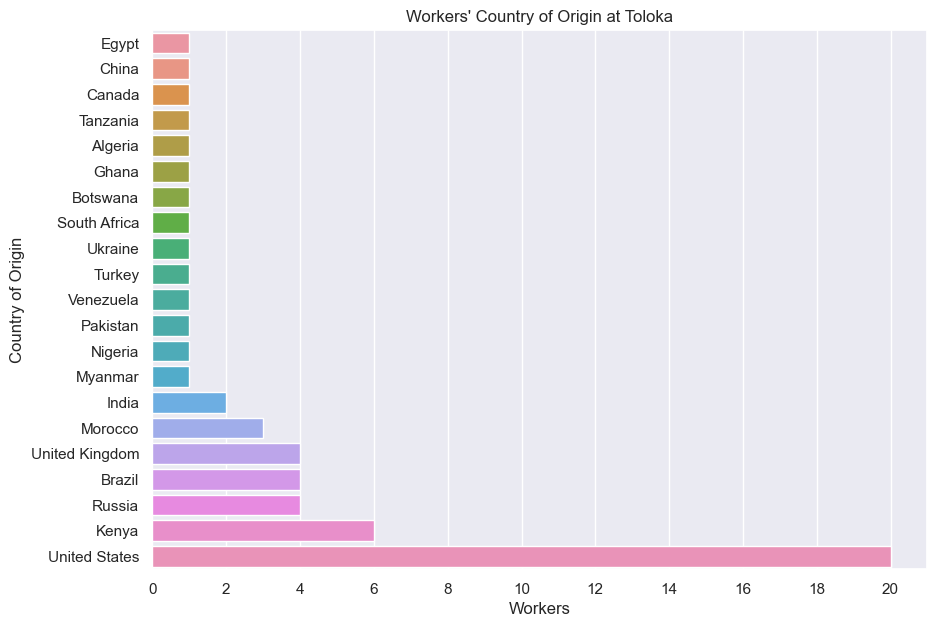

In [6]:
fig, ax_tolo = plt.subplots(1, 1, figsize=(10, 7))
# ax_tolo = sns.countplot(y="home_country", data=df_toloka_short)
ax_tolo = sns.countplot(y="current_country", data=df_toloka_short, order=df_toloka_short['current_country'].value_counts(ascending=True).index)
ax_tolo.set_title("Workers' Country of Origin at Toloka")
ax_tolo.set_xticks(np.arange(0, 21, 2))
ax_tolo.set_ylabel("Country of Origin")
ax_tolo.set_xlabel("Workers")

Text(0.5, 0, 'Workers')

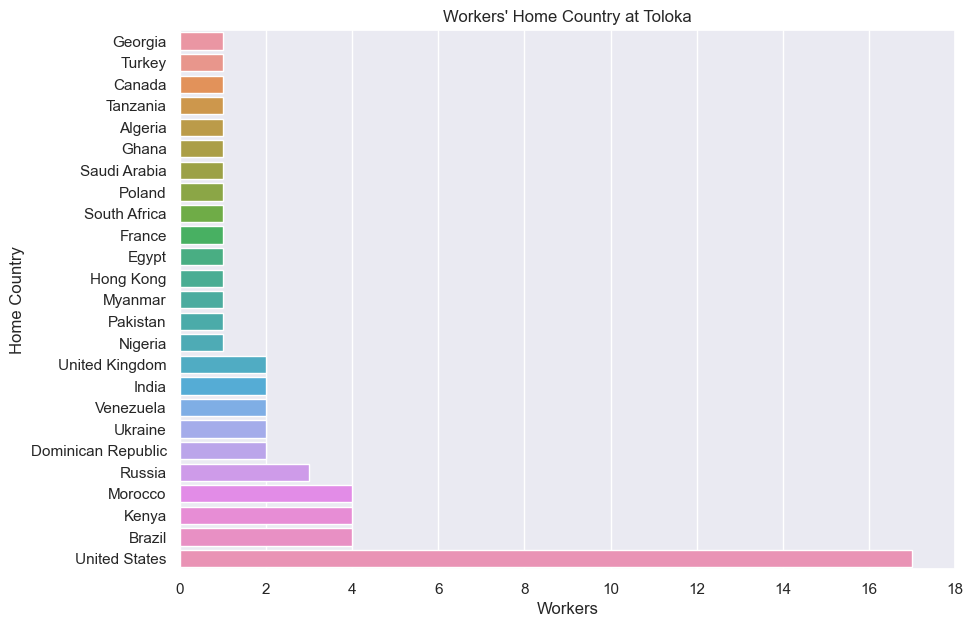

In [7]:
fig, ax_tolo = plt.subplots(1, 1, figsize=(10, 7))
ax_tolo = sns.countplot(y="home_country", data=df_toloka_short, order=df_toloka_short['home_country'].value_counts(ascending=True).index)
ax_tolo.set_title("Workers' Home Country at Toloka")
ax_tolo.set_xticks(np.arange(0, 19, 2))
ax_tolo.set_ylabel("Home Country")
ax_tolo.set_xlabel("Workers")

In [8]:
df_toloka_short = df_toloka_short.rename(columns={'id': 'User'})
merged_toloka = pd.merge(df_toloka, df_toloka_short, on='User', how='left')
merged_toloka = merged_toloka.dropna()
merged_toloka

,ID,Current,Event,Platform,Subtype,Time,Type,User,task_satisfaction,task_motivation,...,age,current_country,home_country,only_one_country,education,group,freq_use,length_use,ability_find_tasks,promptly_find_tasks
1471,1493,chrome://general,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1472,1494,chrome://general,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1473,1495,chrome://appinstall,PLUGIN_INSTALL,OTHER,OTHER,1.642803e+12,OTHER,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1474,1496,chrome://general,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1483,1505,https://toloka.yandex.com/task/31173702/0001db...,TAB_CHANGE,TOLOKA,TASK_STARTED,1.642803e+12,WORKING,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894827,1637343,https://account.skrill.com/wallet/account/logi...,TAB_CHANGE,OTHER,OTHER,1.650931e+12,OTHER,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894828,1637377,chrome://userdata,USER,OTHER,META_DATA,1.650931e+12,API,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894829,1637426,chrome://userdata,USER,OTHER,META_DATA,1.650931e+12,API,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894830,1637498,chrome://configupdate,CONFIG_UPDATE,OTHER,SYSTEM,1.650931e+12,CONFIG,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree


In [9]:
df_tolo_model = merged_toloka.drop(columns=['Current', 'ID', 'User', 'current_country', 'only_one_country', 'group', 'task_satisfaction', 'task_motivation'])
df_tolo_model = df_tolo_model.iloc[150000:180000]
df_tolo_model

,Event,Platform,Subtype,Time,Type,gender,age,home_country,education,freq_use,length_use,ability_find_tasks,promptly_find_tasks
327213,PAGE_BLUR,TOLOKA,TASKS_LIST,1.643817e+12,SEARCHING,Male,35-44 years old,United Kingdom,Master’s degree,Once or twice a week,Between 3 and 6 months,Agree,Agree
327214,TAB_CHANGE,OTHER,OTHER,1.643817e+12,OTHER,Male,18-24 years old,Kenya,Bachelor’s degree,Everyday,Between 6 months and 1 year,Neutral,Disagree
327215,BELL_CLICK,OTHER,OTHER,1.643817e+12,OTHER,Male,35-44 years old,United Kingdom,Master’s degree,Once or twice a week,Between 3 and 6 months,Agree,Agree
327216,PAGE_FOCUS,TOLOKA,TASKS_LIST,1.643817e+12,SEARCHING,Male,35-44 years old,United Kingdom,Master’s degree,Once or twice a week,Between 3 and 6 months,Agree,Agree
327217,PAGE_LAST,TOLOKA,TASKS_LIST,1.643817e+12,SEARCHING,Male,35-44 years old,United Kingdom,Master’s degree,Once or twice a week,Between 3 and 6 months,Agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387656,TAB_CHANGE,OTHER,OTHER,1.644619e+12,OTHER,Male,18-24 years old,United States,Master’s degree,Everyday,Between 6 months and 1 year,Strongly Agree,Strongly Agree
387657,TAB_CHANGE,OTHER,OTHER,1.644619e+12,OTHER,Male,18-24 years old,United States,Master’s degree,Everyday,Between 6 months and 1 year,Strongly Agree,Strongly Agree
387658,TRAINING,TOLOKA,ADDED_TASK,1.644619e+12,LOGS,Male,35-44 years old,Venezuela,"Some college credit, no degree",From five to six days a week,Between 1 and 3 months,Neutral,Neutral
387661,TAB_CLOSED,OTHER,OTHER,1.644619e+12,OTHER,Male,18-24 years old,United States,Master’s degree,Everyday,Between 6 months and 1 year,Strongly Agree,Strongly Agree


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_tolo_model['Event'])
df_tolo_model['Event'] = le.transform(df_tolo_model['Event'])
le.fit(df_tolo_model['Platform'])
df_tolo_model['Platform'] = le.transform(df_tolo_model['Platform'])
le.fit(df_tolo_model['Subtype'])
df_tolo_model['Subtype'] = le.transform(df_tolo_model['Subtype'])
le.fit(df_tolo_model['Type'])
df_tolo_model['Type'] = le.transform(df_tolo_model['Type'])

# le.fit(df_tolo_model['task_satisfaction'])
# df_tolo_model['task_satisfaction'] = le.transform(df_tolo_model['task_satisfaction'])
le.fit(df_tolo_model['gender'])
df_tolo_model['gender'] = le.transform(df_tolo_model['gender'])
le.fit(df_tolo_model['age'])
df_tolo_model['age'] = le.transform(df_tolo_model['age'])
# le.fit(df_tolo_model['current_country'])
# df_tolo_model['current_country'] = le.transform(df_tolo_model['current_country'])
le.fit(df_tolo_model['home_country'])
df_tolo_model['home_country'] = le.transform(df_tolo_model['home_country'])
# le.fit(df_tolo_model['only_one_country'])
# df_tolo_model['only_one_country'] = le.transform(df_tolo_model['only_one_country'])
le.fit(df_tolo_model['education'])
df_tolo_model['education'] = le.transform(df_tolo_model['education'])
# le.fit(df_tolo_model['group'])
# df_tolo_model['group'] = le.transform(df_tolo_model['group'])

le.fit(df_tolo_model['freq_use'])
df_tolo_model['freq_use'] = le.transform(df_tolo_model['freq_use'])
le.fit(df_tolo_model['length_use'])
df_tolo_model['length_use'] = le.transform(df_tolo_model['length_use'])
le.fit(df_tolo_model['ability_find_tasks'])
df_tolo_model['ability_find_tasks'] = le.transform(df_tolo_model['ability_find_tasks'])
le.fit(df_tolo_model['promptly_find_tasks'])
df_tolo_model['promptly_find_tasks'] = le.transform(df_tolo_model['promptly_find_tasks'])

print(df_tolo_model.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 327213 to 387662
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Event                30000 non-null  int32  
 1   Platform             30000 non-null  int32  
 2   Subtype              30000 non-null  int32  
 3   Time                 30000 non-null  float64
 4   Type                 30000 non-null  int32  
 5   gender               30000 non-null  int32  
 6   age                  30000 non-null  int32  
 7   home_country         30000 non-null  int32  
 8   education            30000 non-null  int32  
 9   freq_use             30000 non-null  int32  
 10  length_use           30000 non-null  int32  
 11  ability_find_tasks   30000 non-null  int32  
 12  promptly_find_tasks  30000 non-null  int32  
dtypes: float64(1), int32(12)
memory usage: 1.8 MB
None


In [11]:
target_df = df_tolo_model['home_country']
data_df = df_tolo_model.drop(columns=['home_country'])

scale = MinMaxScaler()

data_df = pd.DataFrame(scale.fit_transform(data_df), columns=data_df.columns)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_df, target_df, test_size=0.20, random_state=50)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.20, random_state=50)
data_df

,Event,Platform,Subtype,Time,Type,gender,age,education,freq_use,length_use,ability_find_tasks,promptly_find_tasks
0,0.25,1.0,0.444444,0.000000e+00,0.777778,1.0,0.5,0.50,1.000000,0.50,0.000000,0.000000
1,0.80,0.0,0.277778,2.369325e-08,0.444444,1.0,0.0,0.00,0.000000,0.75,0.333333,0.333333
2,0.00,0.0,0.277778,3.366949e-08,0.444444,1.0,0.5,0.50,1.000000,0.50,0.000000,0.000000
3,0.40,1.0,0.444444,1.030040e-06,0.777778,1.0,0.5,0.50,1.000000,0.50,0.000000,0.000000
4,0.55,1.0,0.444444,2.673616e-06,0.777778,1.0,0.5,0.50,1.000000,0.50,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.80,0.0,0.277778,9.999459e-01,0.444444,1.0,0.0,0.50,0.000000,0.75,0.666667,1.000000
29996,0.80,0.0,0.277778,9.999603e-01,0.444444,1.0,0.0,0.50,0.000000,0.75,0.666667,1.000000
29997,0.95,1.0,0.000000,9.999789e-01,0.333333,1.0,0.5,0.75,0.333333,0.25,0.333333,0.666667
29998,0.85,0.0,0.277778,9.999970e-01,0.444444,1.0,0.0,0.50,0.000000,0.75,0.666667,1.000000


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
models = [
    ('log', LogisticRegression(max_iter=1000)),
    ('svc', SVC()),
    ('ridge', Ridge()),
    ('lasso', Lasso())
    
]

In [13]:
params = {
    'log': {'C': [0.1, 1.0, 10.0]},
    'svc': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'ridge': {'alpha': [0.1, 1.0, 10.0]},
    'lasso': {'alpha': [0.1, 1.0, 10.0]}
}

In [14]:
from sklearn.model_selection import KFold
best = None
bestAc = 0.0
n_splits = 5
kf = KFold(n_splits=n_splits)

for name, model in models:
    search = GridSearchCV(model, params[name], cv=kf, n_jobs=-1)
    search.fit(Xtrain, Ytrain)
    accuracy = search.score(Xval, Yval)
    if accuracy > bestAc:
        best = search.best_estimator_
        bestAc = accuracy
    print(f"{name} valid accuracy = {accuracy}")

log valid accuracy = 0.9697916666666667
svc valid accuracy = 0.9729166666666667
ridge valid accuracy = 0.32165243046587955
lasso valid accuracy = 0.2027451626328739


In [15]:
from sklearn.metrics import accuracy_score

test = accuracy_score(Ytest, best.predict(Xtest))
print(f"Best model = ({type(best).__name__}) accuracy = {test}")

Best model = (SVC) accuracy = 0.9766666666666667


------------------------------------------------------------------------------------------
Predictions based on a small section of the dataset, and then guessing additional values. 
Then the dataset is checked for accuracy.
------------------------------------------------------------------------------------------

In [28]:
target_df

,home_country
327213,10
327214,5
327215,10
327216,10
327217,10
...,...
431259,11
431260,11
431261,11
431262,11


In [29]:
print(data_df.columns)

Index(['Event', 'Platform', 'Subtype', 'Time', 'Type', 'task_satisfaction',
       'task_motivation', 'gender', 'age', 'current_country',
       'only_one_country', 'education', 'group'],
      dtype='object')


In [30]:
print(df_toloka_short.columns)


Index(['User', 'task_satisfaction', 'task_motivation', 'gender', 'age',
       'current_country', 'home_country', 'only_one_country', 'education',
       'group'],
      dtype='object')


/var/folders/67/1651dwgn4bb30jyxmxysd6900000gn/T/ipykernel_14138/4237845084.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(Xtrain, Ytrain)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       388
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00        84
           4       1.00      1.00      1.00       224
           5       1.00      1.00      1.00      1157
           6       1.00      1.00      1.00        86
           7       1.00      1.00      1.00      1330
           8       1.00      1.00      1.00       102
           9       1.00      1.00      1.00       108
          10       1.00      1.00      1.00        98
          11       1.00      1.00      1.00      5138
          12       1.00      1.00      1.00       733

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



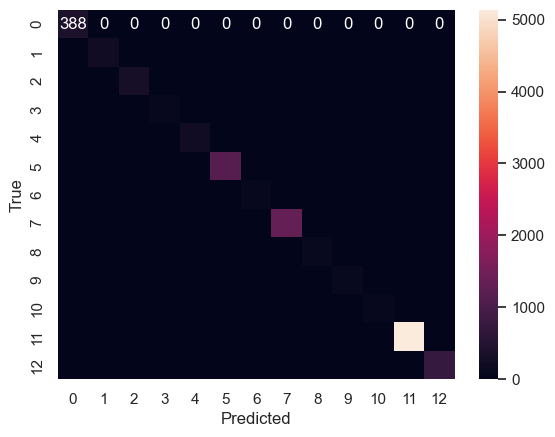

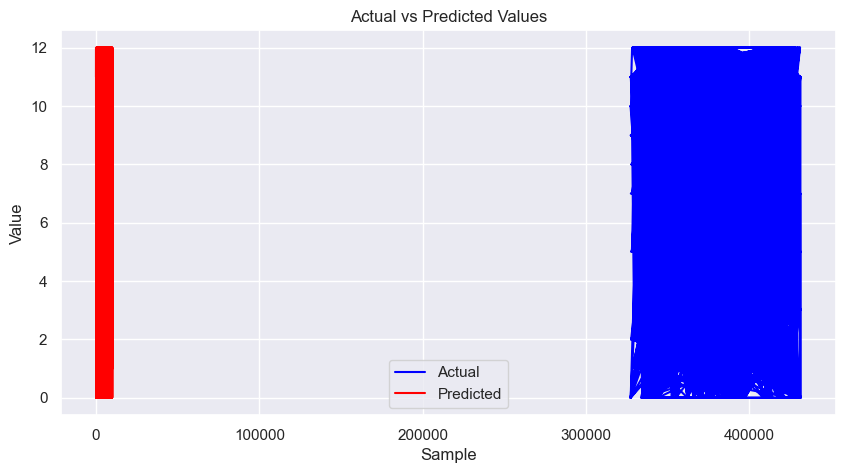

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Split data into train and test sets
#Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_df, target_df, test_size=0.2, random_state=42)

# Perform another split for validation if needed
#Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Model training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(Xtrain, Ytrain)

# Model evaluation
y_pred = rf_classifier.predict(Xtest)
print(classification_report(Ytest, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(Ytest, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

import matplotlib.pyplot as plt

# Plot predicted and actual values
plt.figure(figsize=(10, 5))
plt.plot(Ytest, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

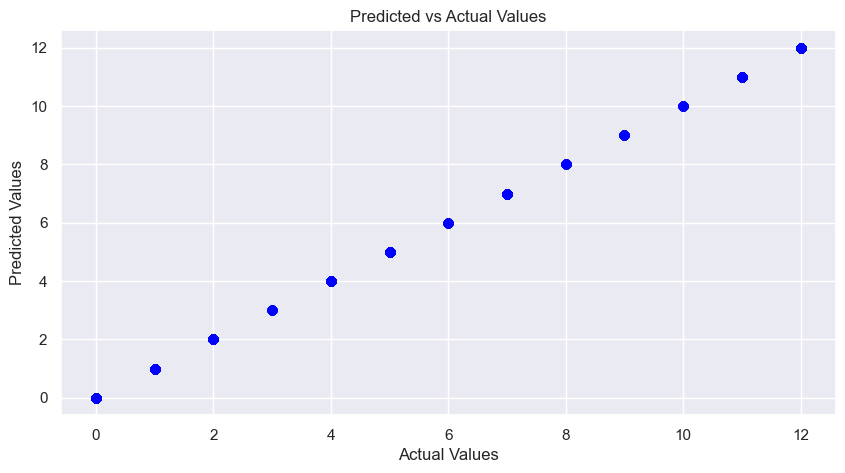

ValueError: shapes (10000,1) and (10000,) not aligned: 1 (dim 1) != 10000 (dim 0)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Plot predicted vs actual values
plt.figure(figsize=(10, 5))
plt.scatter(Ytest, y_pred, color='blue')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Calculate correlation coefficient (r value)
r, _ = pearsonr(Ytest, y_pred)
print("Correlation Coefficient (r value):", r)

In [33]:
# Assuming you have trained your model and made predictions
# Make sure you replace `predicted_country` and `actual_country` with your actual predicted and actual country values

# Plot predicted vs actual country of origin
plt.figure(figsize=(10, 7))
plt.plot(predicted_country, label='Predicted', color='red', marker='o', linestyle='-')
plt.plot(actual_country, label='Actual', color='blue', marker='x', linestyle='--')
plt.title("Predicted vs Actual Country of Origin")
plt.xlabel("Samples")
plt.ylabel("Country")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'predicted_country' is not defined

<Figure size 1000x700 with 0 Axes>